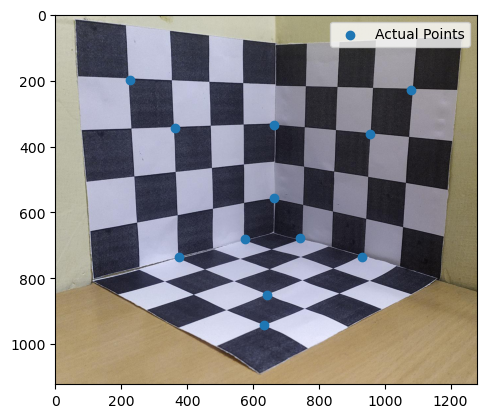

Transformation matrix U : 
[[ 0.61769751  0.          0.         -0.92654627]
 [ 0.          0.61769751  0.         -0.92654627]
 [ 0.          0.          0.61769751 -0.92654627]
 [ 0.          0.          0.          1.        ]]
Transformation matrix T : 
[[ 0.00459691  0.         -3.00714836]
 [ 0.          0.00459691 -2.54362613]
 [ 0.          0.          1.        ]]


In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import rq


#Reading Image and plotting it
img=Image.open('sample_image.jpeg')
plt.imshow(img)
#Reading world coordinates and image coordinates
df=pd.read_excel('sample_data.xlsx')

#Ploting Original Co-ordinates
df_toarray = np.array(df)
plt.scatter(df_toarray[:,3:][:,0],df_toarray[:,3:][:,1],label='Actual Points')
plt.legend()
plt.show()

#No of fiducial points 
n = len(df)

#Extracting the world coordinates and storing them in array
X = np.array(df['X'].tolist())
Y = np.array(df['Y'].tolist())
Z = np.array(df['Z'].tolist())

#Extracting the image coordinates and storing them in array
x = np.array(df['x'].tolist())
y = np.array(df['y'].tolist())

#Calculating centroid of world coordinate plane 
X_centroid = (sum(X))/n
Y_centroid = (sum(Y))/n
Z_centroid = (sum(Z))/n

#Calculating centroid of image coordinate plane
x_centroid = (sum(x))/n
y_centroid = (sum(y))/n


#d_world is average distance of the points from the world centroids in world coordinates
d_world = ((np.sum(np.sqrt((X-X_centroid)**2+(Y-Y_centroid)**2+(Z-Z_centroid)**2))))/n
#d_camera is average distance of the points from the camera centroids in camera coordinates
d_camera = ((np.sum(np.sqrt((x-x_centroid)**2+(y-y_centroid)**2))))/n


#------------------------------STEP1----------------------
#Calculation of the transformation matrices T and U

#Calculation of U
centre_wor = np.array([X_centroid ,Y_centroid ,Z_centroid]).reshape(1,3)
U = np.concatenate((np.eye(3),-1*centre_wor.T),axis=1)
temp = np.array([0,0,0,d_world/np.sqrt(3)]).reshape(1,4)
U = (np.vstack((U,temp)))*(np.sqrt(3)/d_world)
print("Transformation matrix U : ")
print(U)

#Calculation of T
centre_camera = np.array([x_centroid ,y_centroid]).reshape(1,2)
T = np.concatenate((np.eye(2),-1*centre_camera.T),axis=1)
temp = np.array([0,0,d_camera/np.sqrt(2)]).reshape(1,3)
T = (np.vstack((T,temp)))*(np.sqrt(2)/d_camera)
print("Transformation matrix T : ")
print(T)

#world_cor_homo stores the unnormalized world coordinate in homogenous coordinates
homogenous_world = np.vstack((X.reshape(1,n),Y.reshape(1,n),Z.reshape(1,n),np.ones(n).reshape(1,n)))
#camera_cor_homo stores the unnormalized camera coordinate in homogenous coordinates
homogenous_camera = np.vstack((x.reshape(1,n),y.reshape(1,n),np.ones(n).reshape(1,n)))


#normalize_world_cor_homo stores the unnormalized world coordinate in homogenous coordinates
normalize_world_cor_homo = np.dot(U,homogenous_world).T
#normalize_camera_cor_homo stores the unnormalized camera coordinate in homogenous coordinates
normalize_camera_cor_homo = np.dot(T,homogenous_camera).T


In [2]:
#------------------------------STEP2----------------------
#Estimating the normalized projection matrix Pˆ using the DLT method

#P is matrix of size 2nx12 
P = np.ones((1,12))

#Contructing P for all the points
for i in range(n):
    P_i_transpose = normalize_world_cor_homo[i,:].reshape(1,4)
    zeros_tranpose = np.zeros(4).reshape(1,4)
    product_of_x_i_and_P_i_transpose = -1*normalize_camera_cor_homo[i,0]*normalize_world_cor_homo[i,:].reshape(1,4)
    product_of_y_i_and_P_i_transpose = -1*normalize_camera_cor_homo[i,1]*normalize_world_cor_homo[i,:].reshape(1,4)
    t1 = np.hstack((P_i_transpose,zeros_tranpose,product_of_x_i_and_P_i_transpose))
    t2 = np.hstack((zeros_tranpose,P_i_transpose,product_of_y_i_and_P_i_transpose))
    t3 = np.vstack((t1,t2))
    P =  np.concatenate((P,t3))
    
P=P[1:,:]


#Appying DLT method on P to estimate the normalized projection matrix Pˆ
eigen_value, eigen_vector= np.linalg.eig(np.dot(np.transpose(P),P))
P_normalized=eigen_vector[:,np.argmin(eigen_value)].reshape(3,4)
c = (1/np.linalg.norm(P_normalized[2,:3]))
#Denormalizing the projection matrix Pˆ into M
M=np.dot(np.linalg.inv(T),np.dot(P_normalized*c,U))

print("PROJECTION MATRIX : ")
print(M)

PROJECTION MATRIX : 
[[ 9.75360010e+02  7.78609291e+01 -3.77257269e+02 -5.54932591e+03]
 [ 1.28220439e+02  9.54547222e+02  7.21297894e+01 -5.52019868e+03]
 [ 4.54810768e-01  1.41185113e-01  3.93400741e-01 -8.37778479e+00]]


In [3]:
#Using RQ decomposition to get K and R
K, R = rq(M[:,0:3])

#since diagonal values of K are negative using row and col transformation
#to make them positive
K = np.hstack((K[:,0].reshape(3,1),-1*K[:,1].reshape(3,1),-1*K[:,2].reshape(3,1)))
R = np.vstack((R[0,:].reshape(1,3),-1*R[1,:].reshape(1,3),-1*R[2,:].reshape(1,3)))

#Make third diagonal entry of K equal to 1 
K = K/K[2,2]
print("INTRINSIC MATRIX : ")
print(K)
print("")

print("ROTATION MATRIX : ")
print(R)

#Camera center
X_0 = np.dot(-np.linalg.inv(M[:,0:3]),M[:,-1])


INTRINSIC MATRIX : 
[[ 1.49604785e+03 -1.00079903e+01  8.02473014e+02]
 [ 0.00000000e+00  1.45185540e+03  5.80421130e+02]
 [ 0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

ROTATION MATRIX : 
[[ 0.65950383 -0.03183758 -0.75102668]
 [-0.15138293  0.97300751 -0.17418266]
 [ 0.73630015  0.22856675  0.63688251]]


In [4]:
#------------------------------STEP3----------------------
#Calculating intrinsic matrix K, rotation matrix R and the camera center
 
    
#Decomposing M into [A b]
A = M[:,0:3]
b = M[:,-1]


#Setting e as -1
e = 1
#R is epsilon/||a3||
R = e/np.linalg.norm(A[2,:])
#r3 is rho*a3
R3 = R*A[2,:]

#Calculating camera centre
print("CAMERA CENTRE : ")
x_0 = (R*R)*(np.dot(A[0,:],A[2,:]))
print("x0 = ",x_0)
y_0 = (R*R)*(np.dot(A[1,:],A[2,:]))
print("y0 = ",y_0)
print("")

#Calculating cos(0)
COS = ((-1)*np.dot((np.cross(A[0,:],A[2,:])),np.cross(A[1,:],A[2,:])))/(np.linalg.norm(np.cross(A[0,:],A[2,:])*np.linalg.norm(np.cross(A[1,:],A[2,:]))))    
#Calculating 0 from cos(0) by taking cos inverse
TETA = np.math.acos(COS)*180/np.math.pi
print("Theta = ",TETA)
print("")

#Calculating alpha and beta 
SIN = np.sqrt(1-COS**2)
AL =(R*R)*np.linalg.norm(np.cross(A[0,:],A[2,:]))*SIN
print("Alpha = ",AL)
print("")
BET = (R*R)*np.linalg.norm(np.cross(A[1,:],A[2,:]))*SIN
print("Beta = ",BET)
print("")

#Computing r1 and r2
R1 = ((R*R)*(SIN)*(np.cross(A[1,:],A[2,:])))/BET
R2 = np.cross(R3,R1)
#Combining r1,r2,r3 to make rotation matrix R
Ro = np.vstack((R1.reshape(1,3),R2.reshape(1,3),R3.reshape(1,3)))
print("ROTATION MATRIX : ")
print(Ro)
print("")

#Calcuating K
k1 = [AL, (-1)*AL*COS/SIN, x_0]
k2 = [0, BET/SIN, y_0]
k3 = [0,0,1]
K = np.vstack((np.array(k1).reshape(1,3),np.array(k2).reshape(1,3),np.array(k3).reshape(1,3)))
print("INTRINSIC MATRIX : ")
print(K)
print("")

#Calculating Translation matrix t
T = R*np.dot(np.linalg.inv(K),b)
print("TRANSLATION MATRIX : ")
print(T)



CAMERA CENTRE : 
x0 =  802.4730141901927
y0 =  580.4211302794322

Theta =  89.61671877567585

Alpha =  1496.0478466869406

Beta =  1451.8229182676146

ROTATION MATRIX : 
[[ 0.65950383 -0.03183758 -0.75102668]
 [-0.15138293  0.97300751 -0.17418266]
 [ 0.73630015  0.22856675  0.63688251]]

INTRINSIC MATRIX : 
[[ 1.49604785e+03 -1.00079903e+01  8.02473014e+02]
 [ 0.00000000e+00  1.45185540e+03  5.80421130e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

TRANSLATION MATRIX : 
[  1.26510254  -0.73321798 -13.56292465]


In [5]:
#------------------------------STEP4----------------------
#Computing the RMSE(root mean square error) 

#Reconstructing the camera coordinates
def predict(P,homogenous_world):
    p=np.dot(P,homogenous_world).T
    Z=np.dot(P[2,:],homogenous_world).T
    p = p*(1/Z.reshape(n,1))
    return p

#MSE function calculates the RMSE error
def MSE(predicted,actual):
    return np.sqrt(np.mean((predicted-actual)**2))

#Printint the RMSE error
print("RMSE = ",MSE(homogenous_camera.T[:,:-1],np.round(predict(M,homogenous_world)[:,:-1])))


RMSE =  2.336307628146031


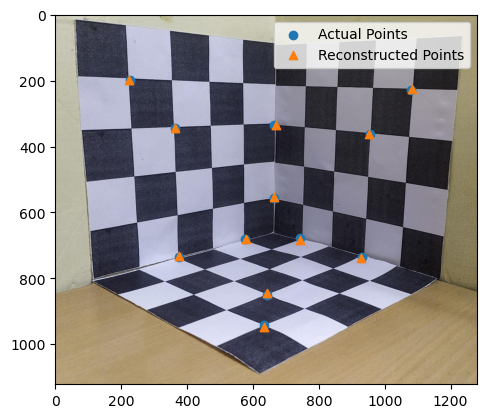

In [6]:
#Visualizing the reconstructed points on the image

plt.imshow(img)
plt.scatter(df_toarray[:,3:][:,0],df_toarray[:,3:][:,1],label='Actual Points')
plt.scatter(predict(M,homogenous_world)[:,0],predict(M,homogenous_world)[:,1],marker='^',label='Reconstructed Points',)
plt.legend()
plt.show()

In [7]:
#------------------------------STEP5----------------------
#Computing the Radial distortion cofficients


j = (np.round(predict(M,homogenous_world)[:,:-1]) - homogenous_camera.T[:,:-1]).T
m = np.round(predict(M,homogenous_world)[:,:-1])
d = np.vstack(((j[:,0].reshape(2,1)),j[:,1].reshape(2,1),j[:,2].reshape(2,1),j[:,3].reshape(2,1),j[:,4].reshape(2,1),j[:,5].reshape(2,1),j[:,6].reshape(2,1),j[:,7].reshape(2,1),
               j[:,8].reshape(2,1),j[:,9].reshape(2,1),j[:,10].reshape(2,1),j[:,11].reshape(2,1)))

d=-1*d
D = np.ones((1,2))

f = np.hstack((Ro,T.reshape(3,1)))

#Contructing D for all the points
for i in range(n):
    h = np.dot(f,normalize_world_cor_homo[0,:].T)
    h = h/h[2]
    g = h[0]*h[0]+h[1]*h[1]
    l1 = m[i][0]-x_0
    l2 = m[i][1]-y_0
    k1 = l1*g
    k2 = l1*g*g
    k3 = l2*g
    k4 = l2*g*g
    v1 = np.zeros((1,2))
    v2 = np.zeros((1,2))
    v1[0][0] = k1
    v1[0][1] = k2
    v2[0][0] = k3
    v2[0][1] = k4
    v3 = np.vstack((v1.reshape(1,2),v2.reshape(1,2)))
    D =  np.concatenate((D,v3))
    
D=D[1:,:]

print("DISTORTION MATRIX : ")
print(np.dot(np.dot(np.linalg.inv(np.dot(D.T,D)),D.T),d))

DISTORTION MATRIX : 
[[-0.02832031]
 [ 0.296875  ]]
